# H&M Fashion Recommendations with Product2Vec

University of Colorado Boulder

DTSA5511 Week 6 - Final Project

## 1. Introduction

Shopping online has created the opportunity to bring fashion to the customer through personalized digital ad experiences. Developing recommendation algorithms based on customer transaction data for H&M addresses this need to bridge the gap between product and online shoppers. The goal of this project is to predict which article each customer will purchase in a 7-day period following the training data timeframe.

For this project, I implemented a Product2Vec approach, which adapts the popular Word2Vec natural language processing technique to the task of product recommendation. This method treats a customer's purchase history as a sentence and individual products as words, allowing the model to learn embeddings of products as vector representations based on their co-occurrence patterns in customer purchase histories.

The overarching purpose of this project is to demonstrate mastery of unsupervised learning technique. Product2Vec approach is particularly well-suited for fashion recommendations because it captures latent relationships between products without requiring explicit attributes as well as naturally modelling the sequntial nature of cutomer purchase much like the sequential nature of words in a sentence. Additionally, it should be able to substitute product relationships.

The MAP@12 evalutation score of 0.002 this implementation achieved provides a foundation for understanding embedding-based recommendation systems.

## 2. Load Modules and Data

The H&M dataset contains three primary data sources including over 31 million rows of transactions, more than 105 thousand items, and over 1.3 million users. Each transaction record includes the customer ID, pruchase data, article ID, and price.

In [1]:
!pip install -q umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import random
import os
import pickle
import logging
import gc
from pathlib import Path
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
from datetime import datetime, timedelta
from tqdm import tqdm
from collections import Counter
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from PIL import Image

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

2025-04-27 22:18:06.763492: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745792287.006927      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745792287.080266      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [72]:
FULL_RUN = True
TRAIN_NEW_MODEL = False
VIZ = True
EVAL = False 
if FULL_RUN:
    SAMPLE_SIZE = None
    MODEL_PATH = '/kaggle/working/product2vec_model.pkl'  
    EMBED_PATH = '/kaggle/working/embeddings.pkl'  
else:
    SAMPLE_SIZE = 250000
    MODEL_PATH = '/kaggle/working/product2vec_model_small.pkl'
    EMBED_PATH = '/kaggle/working/embeddings_small.pkl'
    
TRAIN_SEQUENCES_PATH = '/kaggle/working/train_sequences.pkl'
HISTORIES_PATH = '/kaggle/working/histories.pkl'
SEQUENCES_PATH = '/kaggle/working/sequences.pkl'
GROUND_TRUTH = '/kaggle/working/saved_ground_truth.pkl'
IMG_PATH = '/kaggle/input/h-and-m-personalized-fashion-recommendations/images'
SAMPLE_SUBMISSIONS = '/kaggle/input/h-and-m-personalized-fashion-recommendations/sample_submission.csv'
SUBMISSIONS = '/kaggle/working/submission.csv'

Load in data:

In [4]:
def load_data(full_run=FULL_RUN, chunk_size=1000000):
    print(f"Loading data with {'full' if full_run else 'small'} dataset...")
    
    txs_path = '/kaggle/input/h-and-m-personalized-fashion-recommendations/transactions_train.csv'
    cxs_path = '/kaggle/input/h-and-m-personalized-fashion-recommendations/customers.csv'
    axs_path = '/kaggle/input/h-and-m-personalized-fashion-recommendations/articles.csv'
    
    articles = pd.read_csv(axs_path, dtype={'article_id': str})
    customers = pd.read_csv(cxs_path, dtype={'customer_id': str, 'age': 'float32'})
    customers.fillna(0, inplace=True)
    
    if full_run:

        # Read transactions in chunks for efficiency
        chunks = pd.read_csv(
            txs_path,
            dtype={'article_id': str, 'customer_id': str, 'price': 'float32'},
            parse_dates=['t_dat'],
            chunksize=chunk_size,
            usecols=['t_dat', 'customer_id', 'article_id']  # Load only needed columns
        )
        
        transactions = pd.concat([chunk for chunk in tqdm(chunks, desc="Loading transactions")])
   
    else:
        
        # Sample a smaller dataset
        transactions = pd.read_csv(
            txs_path,
            dtype={'article_id': str, 'customer_id': str, 'price': 'float32'},
            parse_dates=['t_dat'],
            nrows=500000,
            usecols=['t_dat', 'customer_id', 'article_id']
        )
        
        # filter for recent transactions for recency
        recent_date = transactions['t_dat'].max() - pd.Timedelta(days=30)
        transactions = transactions[transactions['t_dat'] >= recent_date]
    
    print(f"Transactions: {transactions.shape}, Articles: {articles.shape}, Customers: {customers.shape}")
    return transactions, articles, customers

In [5]:
transactions, articles, customers = load_data(FULL_RUN)
gc.collect()

Loading data with full dataset...


Loading transactions: 32it [03:13,  6.05s/it]


Transactions: (31788324, 3), Articles: (105542, 25), Customers: (1371980, 7)


0

## 3. Data Exploration

### 3.1 Cursory View

Explore transactions data:

In [73]:
print("Transactions dataset info:")
print(f"Shape: {transactions.shape}")
print(f"Columns: {transactions.columns.tolist()}")
print("\nSample transactions:")
transactions.head()

Transactions dataset info:
Shape: (31788324, 3)
Columns: ['t_dat', 'customer_id', 'article_id']

Sample transactions:


t_dat                                        customer_id  article_id
0 2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...  0663713001
1 2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...  0541518023
2 2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...  0505221004
3 2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...  0685687003
4 2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...  0685687004

Explore articles of clothing:

In [74]:
# Explore articles data
print("Articles dataset info:")
print(f"Shape: {articles.shape}")
print(f"Columns: {articles.columns.tolist()}")
print("\nSample articles:")
articles.head()

Articles dataset info:
Shape: (105542, 25)
Columns: ['article_id', 'product_code', 'prod_name', 'product_type_no', 'product_type_name', 'product_group_name', 'graphical_appearance_no', 'graphical_appearance_name', 'colour_group_code', 'colour_group_name', 'perceived_colour_value_id', 'perceived_colour_value_name', 'perceived_colour_master_id', 'perceived_colour_master_name', 'department_no', 'department_name', 'index_code', 'index_name', 'index_group_no', 'index_group_name', 'section_no', 'section_name', 'garment_group_no', 'garment_group_name', 'detail_desc']

Sample articles:


article_id  product_code          prod_name  product_type_no  \
0  0108775015        108775          Strap top              253   
1  0108775044        108775          Strap top              253   
2  0108775051        108775      Strap top (1)              253   
3  0110065001        110065  OP T-shirt (Idro)              306   
4  0110065002        110065  OP T-shirt (Idro)              306   

  product_type_name  product_group_name  graphical_appearance_no  \
0          Vest top  Garment Upper body                  1010016   
1          Vest top  Garment Upper body                  1010016   
2          Vest top  Garment Upper body                  1010017   
3               Bra           Underwear                  1010016   
4               Bra           Underwear                  1010016   

  graphical_appearance_name  colour_group_code colour_group_name  ...  \
0                     Solid                  9             Black  ...   
1                     Solid                 10             White  ...   
2                    Stripe                 11         Off White  ...   
3                     Solid                  9             Black  ...   
4                     Solid                 10             White  ...   

   department_name index_code        index_name index_group_no  \
0     Jersey Basic          A        Ladieswear              1   
1     Jersey Basic          A        Ladieswear              1   
2     Jersey Basic          A        Ladieswear              1   
3   Clean Lingerie          B  Lingeries/Tights              1   
4   Clean Lingerie          B  Lingeries/Tights              1   

   index_group_name section_no            section_name garment_group_no  \
0        Ladieswear         16  Womens Everyday Basics             1002   
1        Ladieswear         16  Womens Everyday Basics             1002   
2        Ladieswear         16  Womens Everyday Basics             1002   
3        Ladieswear         61         Womens Lingerie             1017   
4        Ladieswear         61         Womens Lingerie             1017   

   garment_group_name                                        detail_desc  
0        Jersey Basic            Jersey top with narrow shoulder straps.  
1        Jersey Basic            Jersey top with narrow shoulder straps.  
2        Jersey Basic            Jersey top with narrow shoulder straps.  
3   Under-, Nightwear  Microfibre T-shirt bra with underwired, moulde...  
4   Under-, Nightwear  Microfibre T-shirt bra with underwired, moulde...  

[5 rows x 25 columns]

Explore customer data:

In [75]:
# Explore customers data
print("Customers dataset info:")
print(f"Shape: {customers.shape}")
print(f"Columns: {customers.columns.tolist()}")
print("\nSample customers:")
customers.head()

Customers dataset info:
Shape: (1371980, 7)
Columns: ['customer_id', 'FN', 'Active', 'club_member_status', 'fashion_news_frequency', 'age', 'postal_code']

Sample customers:


customer_id   FN  Active  \
0  00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...  0.0     0.0   
1  0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...  0.0     0.0   
2  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...  0.0     0.0   
3  00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...  0.0     0.0   
4  00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...  1.0     1.0   

  club_member_status fashion_news_frequency   age  \
0             ACTIVE                   NONE  49.0   
1             ACTIVE                   NONE  25.0   
2             ACTIVE                   NONE  24.0   
3             ACTIVE                   NONE  54.0   
4             ACTIVE              Regularly  52.0   

                                         postal_code  
0  52043ee2162cf5aa7ee79974281641c6f11a68d276429a...  
1  2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...  
2  64f17e6a330a85798e4998f62d0930d14db8db1c054af6...  
3  5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...  
4  25fa5ddee9aac01b35208d01736e57942317d756b32ddd...

### 3.2 Transactions Analysis

Take a look at purchases by day, week, and month. This is important to identify trends in customer behavior. This may be useful for providing recommendations relevant to the season or current week. Based on the plots below we can see peaks in online shopping during summer months, particularly in June. This aligns with summer sales, change of weather, and end of school-year shopping activities. On the daily chart it is evident that the highest daily spike happens around black friday. These temporal patterns suggest that recommendation strategies might benefits from incorporating season context as fashion preferences vary considerably throughout the year.

Date range: 2018-09-20 00:00:00 to 2020-09-22 00:00:00


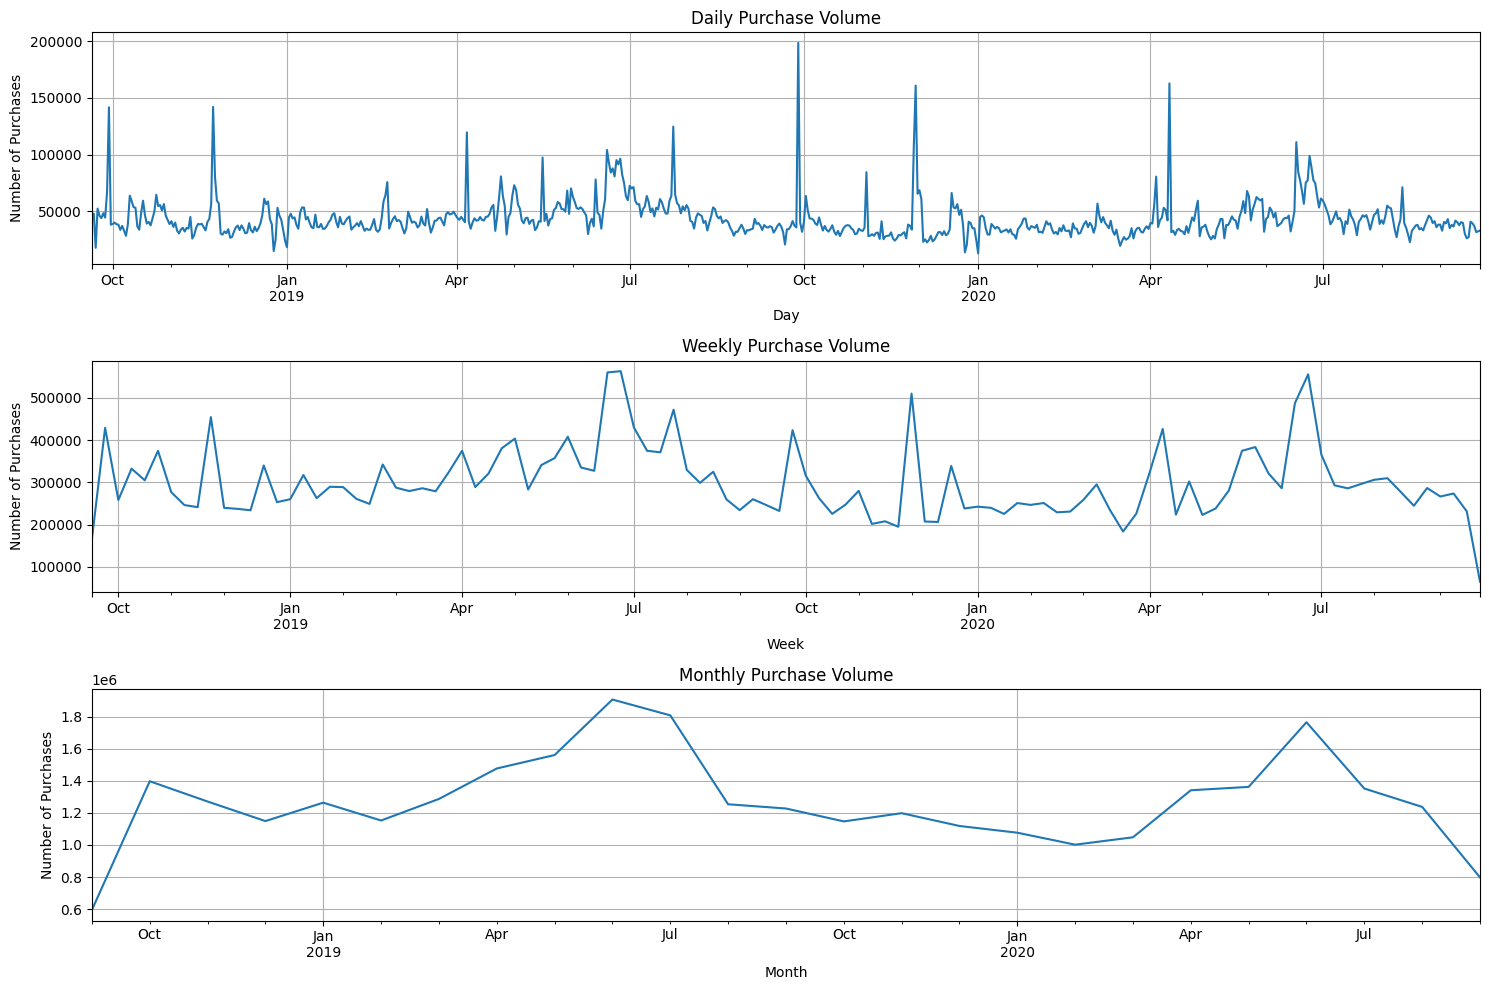

In [76]:
if VIZ:
    print(f"Date range: {transactions['t_dat'].min()} to {transactions['t_dat'].max()}")
    
    transactions['week'] = transactions['t_dat'].dt.to_period('W')
    transactions['month'] = transactions['t_dat'].dt.to_period('M')
    
    daily_purchases = transactions.groupby('t_dat').size()
    weekly_purchases = transactions.groupby('week').size()
    monthly_purchases = transactions.groupby('month').size()
    
    # Plot weekly and monthly trends
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 10))
    
    daily_purchases.plot(ax=ax1)
    ax1.set_title('Daily Purchase Volume')
    ax1.set_ylabel('Number of Purchases')
    ax1.set_xlabel('Day')
    ax1.grid(True)
    
    weekly_purchases.plot(ax=ax2)
    ax2.set_title('Weekly Purchase Volume')
    ax2.set_ylabel('Number of Purchases')
    ax2.set_xlabel('Week')
    ax2.grid(True)
    
    monthly_purchases.plot(ax=ax3)
    ax3.set_title('Monthly Purchase Volume')
    ax3.set_ylabel('Number of Purchases')
    ax3.set_xlabel('Month')
    ax3.grid(True)
    
    plt.tight_layout()
    plt.show()

### 3.3 Customer Analysis

Look at customer purchase frequency on linear and logular scale so we can see the long tail of the distribution. Every non-outlier customer has fewer than 1250 purchases, which is evident on the log scale. There is a large frequency around zero purchases. It is possible to use this insight when building the model, which is likely to work best for repeat customers. With so many customers purchasing so few items, the recommendation power is limited.

Average purchases per customer: 23.334630667241193
Median purchases per customer: 9.0
Min purchases per customer: 1
Max purchases per customer: 1895


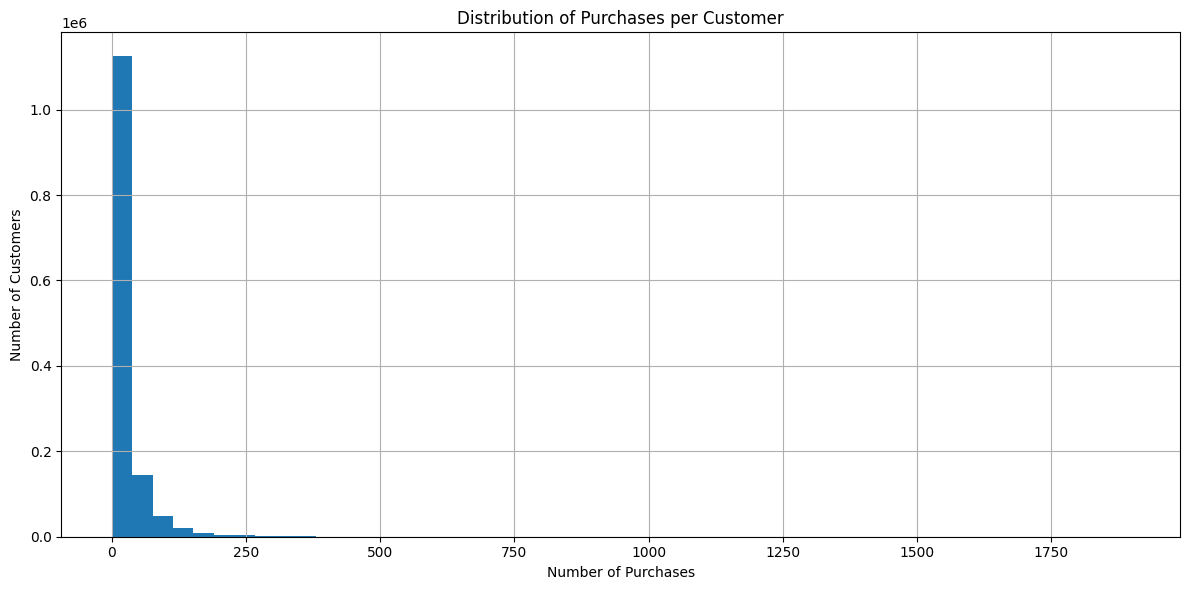

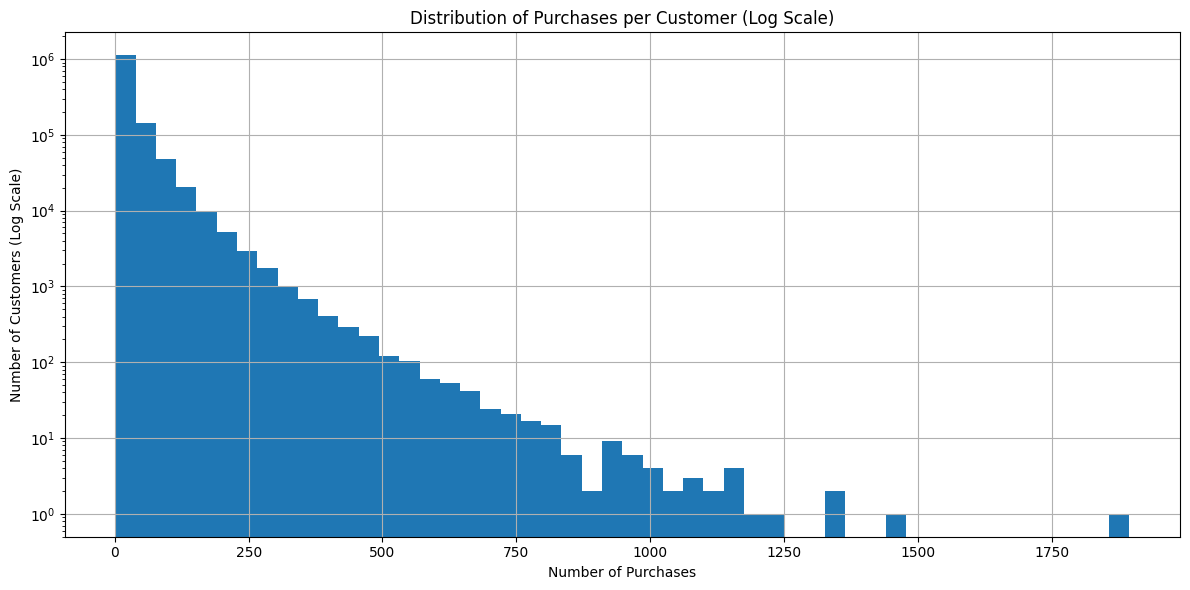

In [77]:
if VIZ:
    # Customer purchase frequency
    customer_purchase_counts = transactions.groupby('customer_id').size()
    
    print(f"Average purchases per customer: {customer_purchase_counts.mean()}")
    print(f"Median purchases per customer: {customer_purchase_counts.median()}")
    print(f"Min purchases per customer: {customer_purchase_counts.min()}")
    print(f"Max purchases per customer: {customer_purchase_counts.max()}")
    
    # lin distribution
    plt.figure(figsize=(12, 6))
    customer_purchase_counts.hist(bins=50)
    plt.title('Distribution of Purchases per Customer')
    plt.xlabel('Number of Purchases')
    plt.ylabel('Number of Customers')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # log distribution
    plt.figure(figsize=(12, 6))
    customer_purchase_counts.hist(bins=50, log=True)
    plt.title('Distribution of Purchases per Customer (Log Scale)')
    plt.xlabel('Number of Purchases')
    plt.ylabel('Number of Customers (Log Scale)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### 3.4 Product Analysis

Now, we can take a look at product popularity by item and by category. The most popular item is a pair of Jade HW Skinny Denim TRS, and the most populr category is trousers. This is useful information to compare to the recommendations made by the model.

In [78]:
product_popularity = transactions['article_id'].value_counts()

print(f"Total unique products purchased: {len(product_popularity)}")
print(f"Average purchases per product: {product_popularity.mean()}")
print(f"Median purchases per product: {product_popularity.median()}")
print(f"Min purchases per product: {product_popularity.min()}")
print(f"Max purchases per product: {product_popularity.max()}")

Total unique products purchased: 104547
Average purchases per product: 304.057734798703
Median purchases per product: 65.0
Min purchases per product: 1
Max purchases per product: 50287


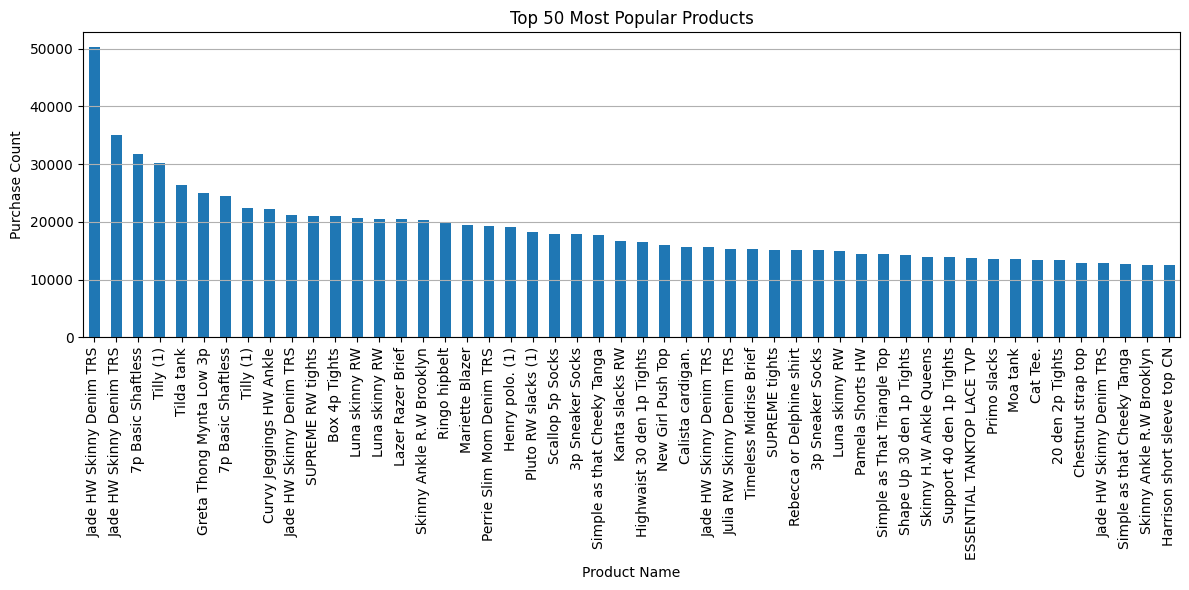

In [79]:
if VIZ:
    # map article_id to product name
    article_names = articles[['article_id', 'prod_name']].set_index('article_id')['prod_name']
    
    # replace article_ids with product names
    product_popularity_named = product_popularity.copy()
    product_popularity_named.index = [article_names.get(id, id) for id in product_popularity.index]
    
    most_popular_article_id = product_popularity.index[0]
    most_popular_article_name = product_popularity_named.index[0]
    
    plt.figure(figsize=(12, 6))
    product_popularity_named.head(50).plot(kind='bar')
    plt.title('Top 50 Most Popular Products')
    plt.xlabel('Product Name')
    plt.ylabel('Purchase Count')
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

In [80]:
def display_item(article_id, title=None, figsize=(6, 6)):

    product_name = article_id
    
    subfolder = article_id[:3]
    item_path = os.path.join(IMG_PATH, subfolder, f"{article_id}.jpg")
    
    plt.figure(figsize=figsize)
    img = Image.open(item_path)
    plt.imshow(img)
    
    plt.title(title, fontsize=14)
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()

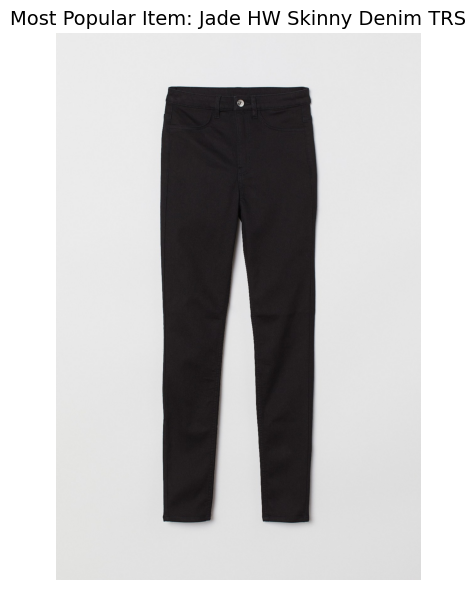

In [81]:
if VIZ:
    display_item(most_popular_article_id, f'Most Popular Item: {most_popular_article_name}')

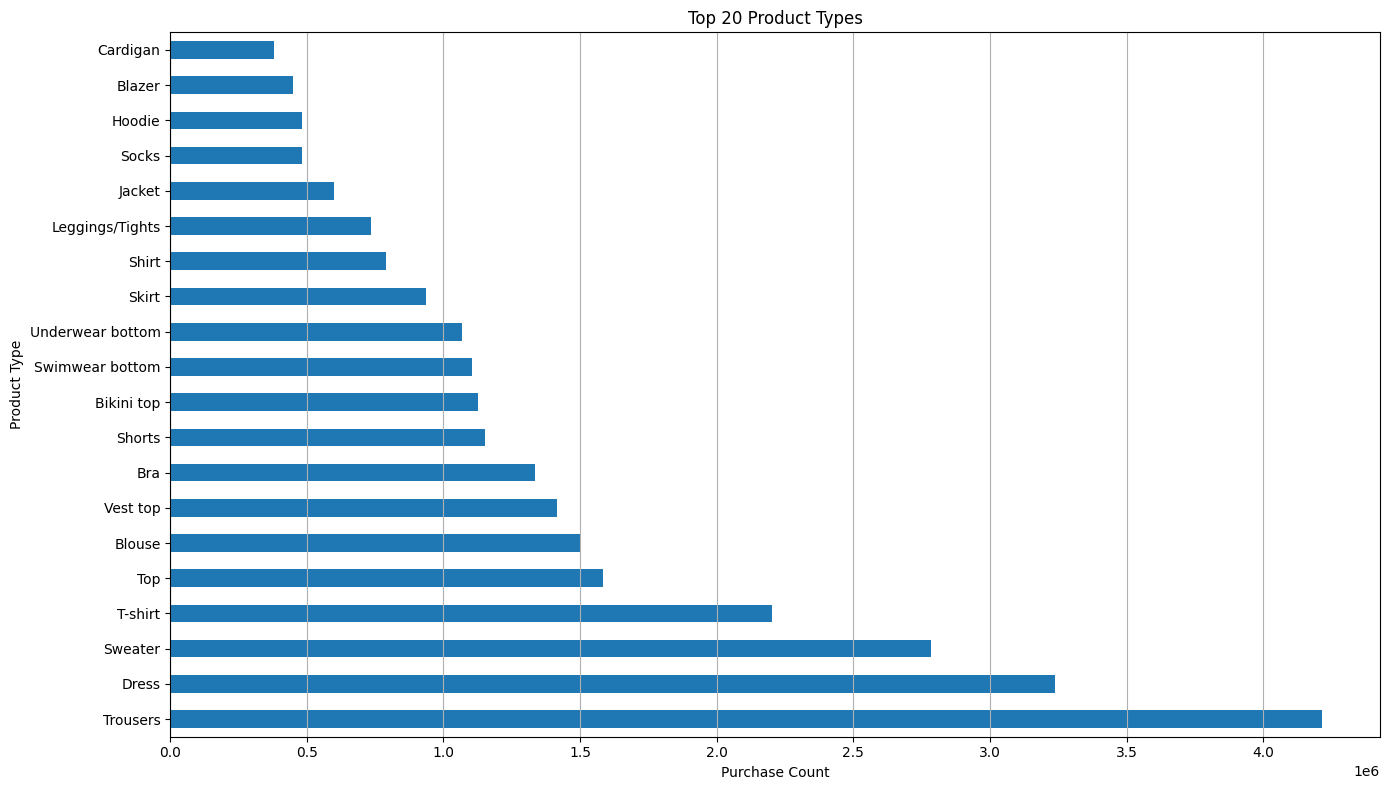

In [82]:
if VIZ:
    transactions_with_products = transactions.merge(articles, on='article_id', how='left')
    
    product_type_counts = transactions_with_products['product_type_name'].value_counts()
    product_group_counts = transactions_with_products['product_group_name'].value_counts()
    
    plt.figure(figsize=(14, 8))
    product_type_counts.head(20).plot(kind='barh')
    plt.title('Top 20 Product Types')
    plt.xlabel('Purchase Count')
    plt.ylabel('Product Type')
    plt.grid(True, axis='x')
    plt.tight_layout()
    plt.show()

## 4. Data Preprocessing

The transaction data was preprocessed to create pruchase sequences for each cutomer. This involved sorting transactions by customer and timestamp, grouping transactions by customer, converting each customer's purchases into ordered sequences, and limiting sequence length to the most recent 50 purchases. 

In early iterations, out of memory errors were common, so I implemented parallel processing with chunking for sequence creation, making the preprocessing pipeline scalable to the full 31 million plus transactions.

In [50]:
def process_group_item(item, min_purchases=2):
    
    customer_id, group = item
    if len(group) >= min_purchases:
        return customer_id, group['article_id'].tolist()[-50:]
    return None

def create_sequences(transactions, min_purchases=2, cache_path=SEQUENCES_PATH, return_dict=False, chunk_size=5000000):
    
    cache_file = Path(cache_path)
    if cache_file.exists():
        print("Loading sequences from cache...")
        with open(cache_file, 'rb') as f:
            return pickle.load(f)
    
    print("Creating transaction sequences...")
    
    sequences = {} if return_dict else []

    # chunk it up for efficiency
    for start_idx in tqdm(range(0, len(transactions), chunk_size), desc="Processing chunks"):
        chunk = transactions[start_idx:start_idx + chunk_size][['customer_id', 't_dat', 'article_id']]
        chunk_sorted = chunk.sort_values(['customer_id', 't_dat'])
        
        groups = chunk_sorted.groupby('customer_id')
        groups_list = list(groups)  # Convert to list to get length
        
        with ProcessPoolExecutor(max_workers=4) as executor:
            results = executor.map(process_group_item, groups_list, [min_purchases] * len(groups_list))
            for result in results:
                if result is not None:
                    cid, seq = result
                    if return_dict:
                        sequences[cid] = seq
                    else:
                        sequences.append(seq)
        
        del chunk, chunk_sorted, groups_list, results
        gc.collect()
    
    print(f"Created {len(sequences)} sequences")
    
    with open(cache_file, 'wb') as f:
        pickle.dump(sequences, f)
    
    return sequences

For evaluation, I created time-based train, validation, and test splits. The training data had all transactions before the validation period. The validation data was limited to 7 days before the test period, and the test data had the final 7 days. This approach mimics a real-wprld scenario where we use historical data to predict future purchases, respecting the temporal and trendy nature of fashion recommendations.

In [51]:
def create_time_splits(transactions, test_days=7, validation_days=7):

    print("Creating time splits...")
    
    # set split dates
    max_date = transactions['t_dat'].max()
    test_start_date = max_date - timedelta(days=test_days-1)
    validation_start_date = test_start_date - timedelta(days=validation_days)
    
    # split data
    train = transactions[transactions['t_dat'] < validation_start_date]
    validation = transactions[(transactions['t_dat'] >= validation_start_date) & 
                              (transactions['t_dat'] < test_start_date)]
    test = transactions[transactions['t_dat'] >= test_start_date]
    
    print(f"Train period: until {validation_start_date - timedelta(days=1)}")
    print(f"Validation period: {validation_start_date} to {test_start_date - timedelta(days=1)}")
    print(f"Test period: {test_start_date} to {max_date}")
    
    print(f"Train shape: {train.shape}")
    print(f"Validation shape: {validation.shape}")
    print(f"Test shape: {test.shape}")
    
    return {
        'train': train,
        'validation': validation,
        'test': test
    }

In [52]:
def create_ground_truth(transactions, customer_ids_set, start_date, days=7):

    print("Creating ground truth...")
    
    end_date = start_date + timedelta(days=days-1)
    
    # filter transactions for the evaluation period
    eval_transactions = transactions[(transactions['t_dat'] >= start_date) & 
                                    (transactions['t_dat'] <= end_date)]
    
    # using set for faster lookups for customers we actually care about
    eval_transactions = eval_transactions[eval_transactions['customer_id'].isin(customer_ids_set)]
    
    # ground truth dictionary
    ground_truth = {}
    
    for customer_id, group in eval_transactions.groupby('customer_id'):
        # get unique purchased articles
        purchased_articles = group['article_id'].unique().tolist()
        ground_truth[customer_id] = purchased_articles
    
    print(f"Created ground truth for {len(ground_truth)} customers")
    return ground_truth

## 5. Product2Vec Model Implementation

The core of this project is the Product2Vec model that leverages Word2Vec to learn product embeddings from purchase sequences. The model architecture below has key components, starting with the embedding learning using skip-gram to predict context products given a target product. Each product is represented as a dense 100-dimensional vector. The default window size of 5 captures local purchase patterns. Tunable hyper parameters include vector size, windows, min count of products, skip gram, epochs, and hierarchical softmax. The fine-tuning in this notebook is limited, and will be considered part of future work as much of my effort was spent reducing run time and memory management.

The generation process involves retrieving a customer's purchase history, aggregaring the embedding of purchased products with recency bias, finding products with embeddings similar to the aggregate vector, excluding already purchased items (how annoying is it to be recommended a product after you purchase it), and recommending the top n most similar products.

In [53]:
# Product2Vec model for learning product embeddings from purchase sequences using word2vec
class Product2Vec:

    def __init__(self, vector_size=100, window=5, min_count=5, 
                 sg=1, workers=4, epochs=10, hs=1):

        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.sg = sg
        self.workers = workers
        self.epochs = epochs
        self.hs = hs
        self.model = None
        self.item_embeddings = None
        
    def fit(self, sequences):

        print(f"Training Product2Vec with {len(sequences)} sequences...")

        # filter rare items
        item_counts = Counter(item for seq in sequences for item in seq)
        sequences = [[item for item in seq if item_counts[item] >= self.min_count] for seq in sequences]
        sequences = [seq for seq in sequences if seq]
        
        # train
        self.model = Word2Vec(
            sentences=sequences,
            vector_size=self.vector_size,
            window=self.window,
            min_count=self.min_count,
            sg=self.sg,
            workers=self.workers,
            epochs=self.epochs,
            hs=self.hs
        )
        
        self.item_embeddings = {item: self.model.wv[item] for item in self.model.wv.index_to_key}
        print(f"Model trained with {len(self.item_embeddings)} items")
        return self
        
    def get_embedding(self, item_id):
        return self.model.wv[item_id]
    
    def get_similar_items(self, item_id, top_n=12): # playing with top_n, was 10
        return self.model.wv.most_similar(item_id, topn=top_n)

    
    def get_recommendations(self, history, top_n=12, strategy='mean', 
                           recency_bias=True, exclude_history=True):

        # filter history items that are in the vocabulary
        valid_history = [item for item in history if item in self.model.wv.key_to_index]
        
        if not valid_history:
            return []
        
        # apply recency bias if enabled
        if recency_bias and len(valid_history) > 1:
            # more recent items get higher weights
            weights = np.linspace(0.5, 1.0, len(valid_history))
        else:
            weights = np.ones(len(valid_history))
        
        # get embeddings for history items
        history_embeddings = [self.get_embedding(item) for item in valid_history]
        
        # combine embeddings based on strategy
        if strategy == 'mean':
            user_vector = np.mean(history_embeddings, axis=0)
        elif strategy == 'weighted_mean':
            user_vector = np.average(history_embeddings, axis=0, weights=weights)
        elif strategy == 'recent':
            # use only the most recent item
            user_vector = history_embeddings[-1]
        else:
            raise ValueError(f"Unknown strategy: {strategy}")
        
        # find similar items to the user vector
        items_to_exclude = set(valid_history) if exclude_history else set()
        similar_items = self._find_similar_items(user_vector, top_n, items_to_exclude)
        
        return [item_id for item_id, _ in similar_items]
    
    def _find_similar_items(self, vector, top_n=12, exclude_items=None):

        if exclude_items is None:
            exclude_items = set()
        
        # norm the query vector
        norm_vector = vector / np.linalg.norm(vector)
        
        # get all item vectors
        all_items = [(item, self.model.wv[item]) for item in self.model.wv.index_to_key 
                    if item not in exclude_items]
        
        # get similarities
        similarities = [(item, np.dot(norm_vector, vec / np.linalg.norm(vec))) 
                       for item, vec in all_items]
        
        # sort similarities descendingly 
        similarities.sort(key=lambda x: x[1], reverse=True)
        
        return similarities[:top_n]
    
    def save(self, model_path, embeddings_path):
        self.model.save(model_path)
        with open(embeddings_path, 'wb') as f:
            pickle.dump(self.item_embeddings, f)
    
    @classmethod # access class and load model
    def load(cls, model_path, embeddings_path=None):

        # create a new instance
        instance = cls()
        
        # load the Word2Vec model
        instance.model = Word2Vec.load(model_path)
        
        # load embeddings if path provided, otherwise extract from model
        if embeddings_path and os.path.exists(embeddings_path):
            with open(embeddings_path, 'rb') as f:
                instance.item_embeddings = pickle.load(f)
        else:
            instance.item_embeddings = {item: instance.model.wv[item] 
                                     for item in instance.model.wv.index_to_key}
        
        return instance

In [54]:
def generate_user_recommendations(model, user_histories, popular_items, top_n=12, 
                                strategy='weighted_mean', recency_bias=True):
    
    print(f"Generating recommendations for {len(user_histories)} users...")
    
    recommendations = {}
    
    for user_id, history in tqdm(user_histories.items()):
        recs = model.get_recommendations(
            history=history,
            top_n=top_n,
            strategy=strategy,
            recency_bias=recency_bias
        )
        
        # If not enough recommendations, pad with popular items
        if len(recs) < top_n:
            remaining_popular = [item for item in popular_items if item not in recs]
            needed = top_n - len(recs)
            recs.extend(remaining_popular[:needed])
                
        recommendations[user_id] = recs[:top_n]
    
    print(f"Generated recommendations for {len(recommendations)} users")
    return recommendations

## 6. Model Training

In [55]:
gc.collect()

0

In [22]:
popular_items = transactions['article_id'].value_counts().head(12).index.tolist()  # Optimize with head()
gc.collect()

base_params = {
    'vector_size': 128,
    'window': 3,
    'min_count': 10,
    'sg': 1,
    'workers': 4,
    'epochs': 15,
    'hs': 0
}

if TRAIN_NEW_MODEL:
    
    train_sequences = create_sequences(
        transactions,
        min_purchases=2,
        cache_path=TRAIN_SEQUENCES_PATH,
        return_dict=False,
        chunk_size=5000000
    )
    
    customer_histories = create_sequences(
        transactions,
        min_purchases=1,
        cache_path=HISTORIES_PATH,
        return_dict=True,
        chunk_size=5000000
    )
    
    base_model = Product2Vec(**base_params)
    base_model.fit(train_sequences)
    base_model.save('/kaggle/working/product2vec_model.pkl', '/kaggle/working/embeddings.pkl')
    del train_sequences
    
    gc.collect()
        
else:
    
    base_model = Product2Vec.load('/kaggle/working/product2vec_model.pkl', '/kaggle/working/embeddings.pkl')
    
    customer_histories = create_sequences(
        transactions,
        min_purchases=1,
        cache_path=HISTORIES_PATH,
        return_dict=True,
        chunk_size=5000000
    )
    
    gc.collect()

Creating transaction sequences...


Processing chunks: 100%|██████████| 7/7 [34:21<00:00, 294.45s/it]


Created 3343183 sequences
Loading sequences from cache...
Training Product2Vec with 3343183 sequences...
Model trained with 82582 items


## 7. Model Evaluation

The moddel was evaluated using the Mean Average Precision at 12 (MAP@12) metric, which rewards models for placing relevant items higher in the recommendation list. For each customer, the ground truth consists of the articles they actually purchased in the 7-day validation period. Some optimization efforts includes batch processing of users, precomputation of embeddings, parallel computation, and early filtering of invalid histories.

In [56]:
if EVAL:
    # Create time-based splits
    splits = create_time_splits(transactions, test_days=7, validation_days=14)
    train_df = splits['train']
    validation_df = splits['validation']
    test_df = splits['test']

In [57]:
if EVAL:
    if TRAIN_NEW_MODEL:
        
        customer_ids_set = set(customer_histories.keys())
        
        validation_ground_truth = create_ground_truth(
            validation_df, 
            customer_ids_set, 
            validation_df['t_dat'].min(),
            days=7
        )
        
        with open(GROUND_TRUTH, 'wb') as f:
            pickle.dump(validation_ground_truth, f)
            
    else:
        
        with open(GROUND_TRUTH, 'rb') as f:
            validation_ground_truth = pickle.load(f)
        
        print('Loaded ground truth from save file')

In [58]:
def map_at_k_kaggle(actual, predicted, k=12):
    
    ap_at_k = []
    for act, pred in zip(actual, predicted):
        
        if len(act) > 0:
            pred_k = pred[:k]
            precision_sum = 0
            num_correct = 0
            
            for i, item in enumerate(pred_k):
                if item in act:
                    num_correct += 1
                    precision_sum += num_correct / (i + 1)
            
            ap = precision_sum / min(len(act), k) if len(act) > 0 else 0
            ap_at_k.append(ap)
            
    return np.mean(ap_at_k) if ap_at_k else 0

In [59]:
def evaluate_model(model, user_histories, ground_truth, top_n=12, strategy='weighted_mean', 
                  recency_bias=True, n_workers=4):
    
    print(f"Evaluating model with strategy '{strategy}'...")
    
    # precompute embedding matrix
    vocab_items = list(model.model.wv.index_to_key)
    embedding_matrix = np.array([model.model.wv[item] for item in vocab_items])
    
    # filter valid users to save time
    eval_users = [uid for uid in ground_truth.keys() if uid in user_histories and user_histories[uid]]
    print(f"Evaluating for {len(eval_users)} users")
    
    def process_batch(user_batch):
        batch_recs = []
        batch_actual = []
        
        for user_id in user_batch:
            history = user_histories[user_id]
            actual = ground_truth[user_id]
            
            # filter valid history 
            valid_history = [item for item in history if item in model.model.wv.key_to_index]
            if not valid_history:
                continue
                
            # compute user vector
            history_embeddings = np.array([model.model.wv[item] for item in valid_history])
            weights = np.linspace(0.5, 2.0, len(valid_history)) if recency_bias else np.ones(len(valid_history))
            user_vector = np.average(history_embeddings, axis=0, weights=weights)
            
            # Batch similarity computation
            norm_user = user_vector / np.linalg.norm(user_vector)
            norm_embeddings = embedding_matrix / np.linalg.norm(embedding_matrix, axis=1, keepdims=True)
            similarities = np.dot(norm_embeddings, norm_user)
            
            # exlude history items
            valid_indices = [i for i, item in enumerate(vocab_items) if item not in set(valid_history)]
            similarities = similarities[valid_indices]
            valid_items = [vocab_items[i] for i in valid_indices]
            
            # Top-N recs
            top_indices = np.argsort(similarities)[::-1][:top_n]
            recs = [valid_items[i] for i in top_indices]
            
            batch_recs.append(recs)
            batch_actual.append(actual)
        
        return batch_recs, batch_actual
    
    batch_size = 1000
    actual_lists = []
    pred_lists = []
    
    with ThreadPoolExecutor(max_workers=n_workers) as executor:
        
        futures = [
            executor.submit(process_batch, eval_users[i:i + batch_size])
            for i in range(0, len(eval_users), batch_size)
        ]
        
        for future in tqdm(futures, desc="Evaluating batches"):
            recs, actual = future.result()
            pred_lists.extend(recs)
            actual_lists.extend(actual)
    
    map_score = map_at_k_kaggle(actual_lists, pred_lists, k=top_n)
    
    # coverage metrics
    all_items = set(item for items in ground_truth.values() for item in items)
    recommended_items = set(item for items in pred_lists for item in items)
    item_coverage = len(recommended_items & all_items) / len(all_items) if all_items else 0
    customer_coverage = len(pred_lists) / len(ground_truth) if ground_truth else 0
    
    return {
        'map@12': map_score,
        'item_coverage': item_coverage,
        'customer_coverage': customer_coverage
    }

The results of evaluation shows that the MAP@12 is 0.002, the item coverage is 0.564, and the customer coverage is 0.723.

While the MAP@12 score might seem low, it's actually within the expected range for challenging recommendation tasks like fashion, several factors contribute to this. First, fashion is inherently difficult to predict because it changes with seasons and is usually biased by novelty (perhaps something that can be implemented in future iterations). The sparsity of the dataset also contributes to this since most customers only purchase a tiny fraction of the available items, and not every customer was active.

The item and customer coverage metrics are more optimistic. They show that the model recommends a substantial portion of relevant items and can generate recommendations for most customers.

In [60]:
if EVAL:
    # evaluate model
    results = evaluate_model(base_model, customer_histories, validation_ground_truth)
    print(f"MAP@12: {results['map@12']}")
    print(f"Item coverage: {results['item_coverage']}")
    print(f"Customer coverage: {results['customer_coverage']}")

## 8. Model Analysis and Visualizations

Example recommendations for random customers demonstrated that the model recommends products that are stylistically coherent with past purchases. For instance, a customer who purchased casual tops and jeans received recommendations for similar casual items, suggesting the embeddings capture meaningful style patterns. Using the eyeball method, the model seems to be working well.

In [83]:
def display_multiple_items(article_ids, articles_df=None, title="Product Recommendations"):
    
    n_items = min(len(article_ids), 12)  
    cols = int(np.ceil(np.sqrt(n_items)))  
    rows = int(np.ceil(n_items / cols))    
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10), squeeze=False)
    fig.suptitle(title, fontsize=16)
    
    axes_flat = axes.flatten()
    
    for i, article_id in enumerate(article_ids[:12]):
        if i >= n_items:
            break
            
        # get subfolder from article_id
        subfolder = article_id[:3]
        
        # build the full path correctly
        full_path = f"{IMG_PATH}/{subfolder}/{article_id}.jpg"
            
        if os.path.exists(full_path):
            img = Image.open(full_path)
            axes_flat[i].imshow(img)
            axes_flat[i].set_title(f"Article: {article_id}", fontsize=10)
        
        else:
            print(f'Image not found for article {article_id}')
            axes_flat[i].set_facecolor('lightgray')
            axes_flat[i].text(0.5, 0.5, f'No image\n{article_id}', 
                         horizontalalignment='center', 
                         verticalalignment='center')
        
        axes_flat[i].axis('off')
    
    # hide unused subplots
    for j in range(n_items, len(axes_flat)):
        axes_flat[j].set_visible(False)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

In [84]:
def show_customer_recommendations(customer_id, model, transactions, articles_df=None):

    # get customer purchase history
    history = transactions[transactions['customer_id'] == customer_id]['article_id'].tolist()
    
    # generaet recommendations
    recommendations = model.get_recommendations(
        history=history,
        top_n=12,
        strategy='weighted_mean',
        recency_bias=True
    )
    
    # Display purchase history
    print(f"\nCustomer purchase history: {len(history)} items")
    if len(history) == 1:
        display_item(history[0], title=f"Customer Purchase History {customer_id}")
    elif len(history) == 0:
        print(f'no purchase history for {customer_id}')
    else:
        display_multiple_items(history[:12], articles_df=articles_df, title=f"{customer_id} Purchase History ")
    
    # show recommendations
    print(f"\nDisplaying {len(recommendations)} recommendations for customer {customer_id}")
    if len(recommendations) == 1:
        display_item(recommendations, title=f"Recommendations for Customer {customer_id}")
    elif len(recommendations) == 0:
        print(f'no recommendations history for {customer_id}')
    else:
        display_multiple_items(recommendations, articles_df=articles_df, title=f"Recommendations for {customer_id}")
    
    return recommendations

In [85]:
def visualize_embeddings(model, articles_df, dim_reduction='tsne', n_items=1000, 
                        color_by='product_group_name', figsize=(12, 10)):

    # get embeddings for visualization
    vocab_items = list(model.model.wv.key_to_index.keys())
    
    # dim reduction options
    if dim_reduction == 'tsne':
        reducer = TSNE(n_components=2, random_state=19)
    elif dim_reduction == 'umap':
        reducer = umap.UMAP(random_state=19)
    
    # sample items if there are too many
    if len(vocab_items) > n_items:
        sample_items = random.sample(vocab_items, n_items)
    else:
        sample_items = vocab_items
    
    item_embeddings = np.array([model.model.wv[item] for item in sample_items])
    
    reduced_embeddings = reducer.fit_transform(item_embeddings)
    
    # create df for plotting
    plot_df = pd.DataFrame({
        'x': reduced_embeddings[:, 0],
        'y': reduced_embeddings[:, 1],
        'article_id': sample_items
    })
    
    plot_df = plot_df.merge(articles_df, on='article_id', how='left')
    
    plt.figure(figsize=figsize)
    sns.scatterplot(data=plot_df, x='x', y='y', hue=color_by, alpha=0.7, s=20)
    plt.title(f'Product Embeddings Visualization ({dim_reduction.upper()})')
    plt.xlabel(f'{dim_reduction.upper()} Dimension 1')
    plt.ylabel(f'{dim_reduction.upper()} Dimension 2')
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    return plt.gcf()

In [86]:
# find similar products for an example item
articles_in_vocab = list(base_model.model.wv.key_to_index.keys())
example_article_id = random.choice(articles_in_vocab)

similar_items = base_model.get_similar_items(example_article_id, top_n=5)

print(f"Similar products to {example_article_id}:")

for similar_id, similarity in similar_items:
    print(f"  {similar_id} (Similarity: {similarity})")

Similar products to 0747994002:
  0769535001 (Similarity: 0.8376265168190002)
  0664024003 (Similarity: 0.8298726677894592)
  0812938001 (Similarity: 0.8248588442802429)
  0821798002 (Similarity: 0.82402104139328)
  0778660003 (Similarity: 0.8233560919761658)


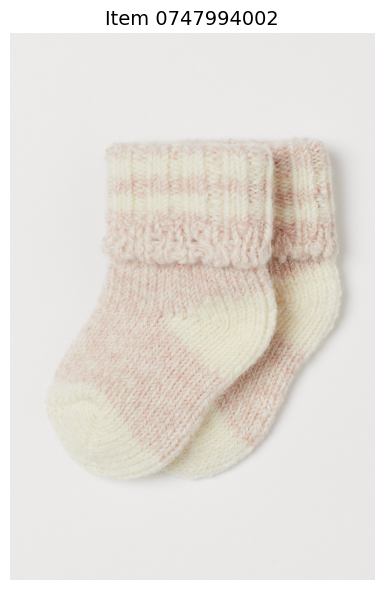

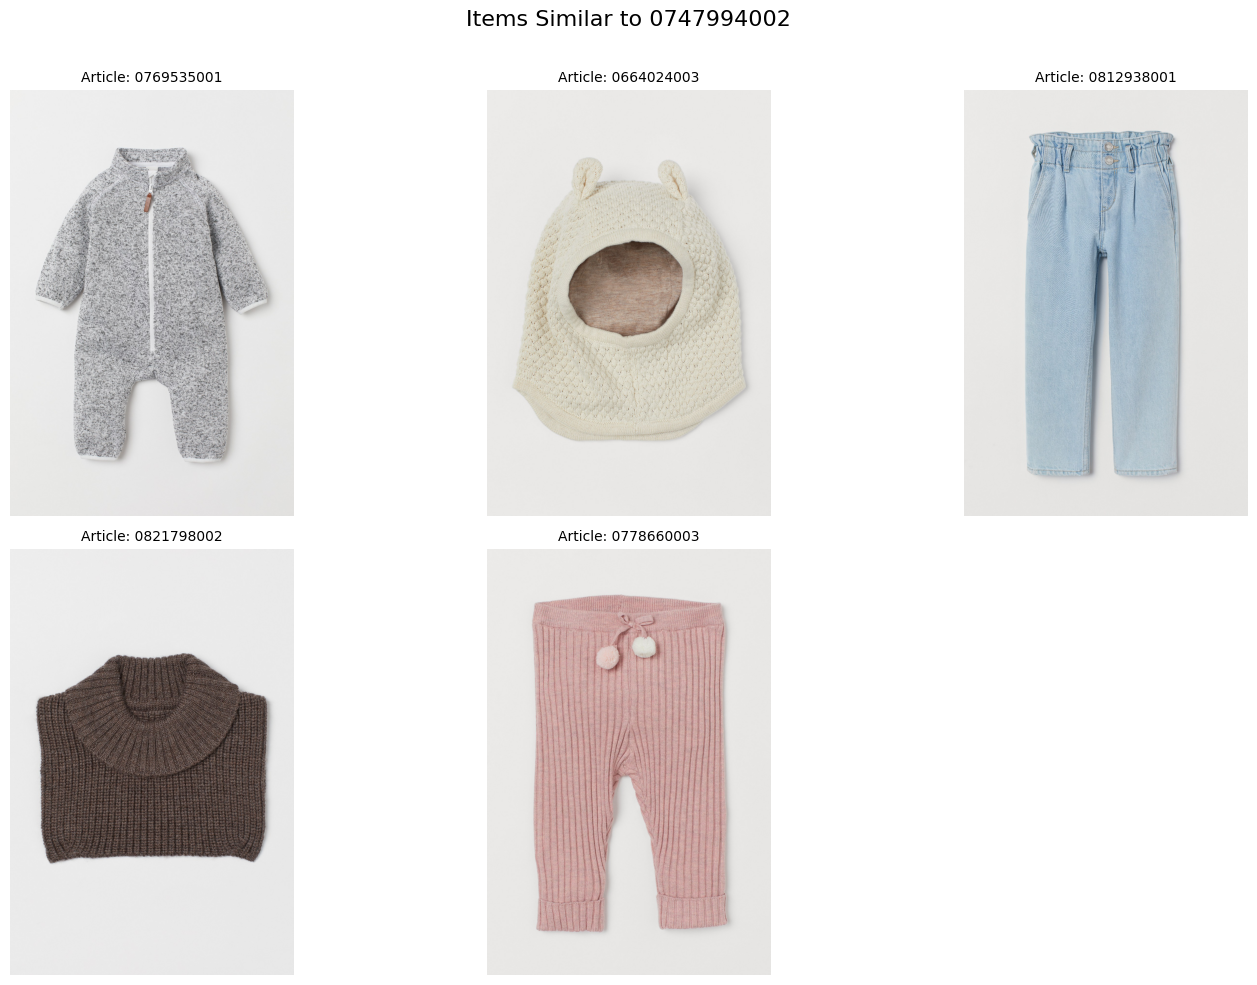

In [87]:
if VIZ:
    similar_item_ids = [i for i, x in similar_items] 
    display_item(example_article_id, f'Item {example_article_id}')
    display_multiple_items(similar_item_ids, title=f"Items Similar to {example_article_id}")

Recommendations for customer 2e03811d248ef883eaebfbdc646bdd128733174cb9ad99b7dc9540f75e115462:
['0801856002', '0785226001', '0808918003', '0835457001', '0665481012', '0698597004', '0832361003', '0769102019', '0820487002', '0863001001', '0832359002', '0814118005']




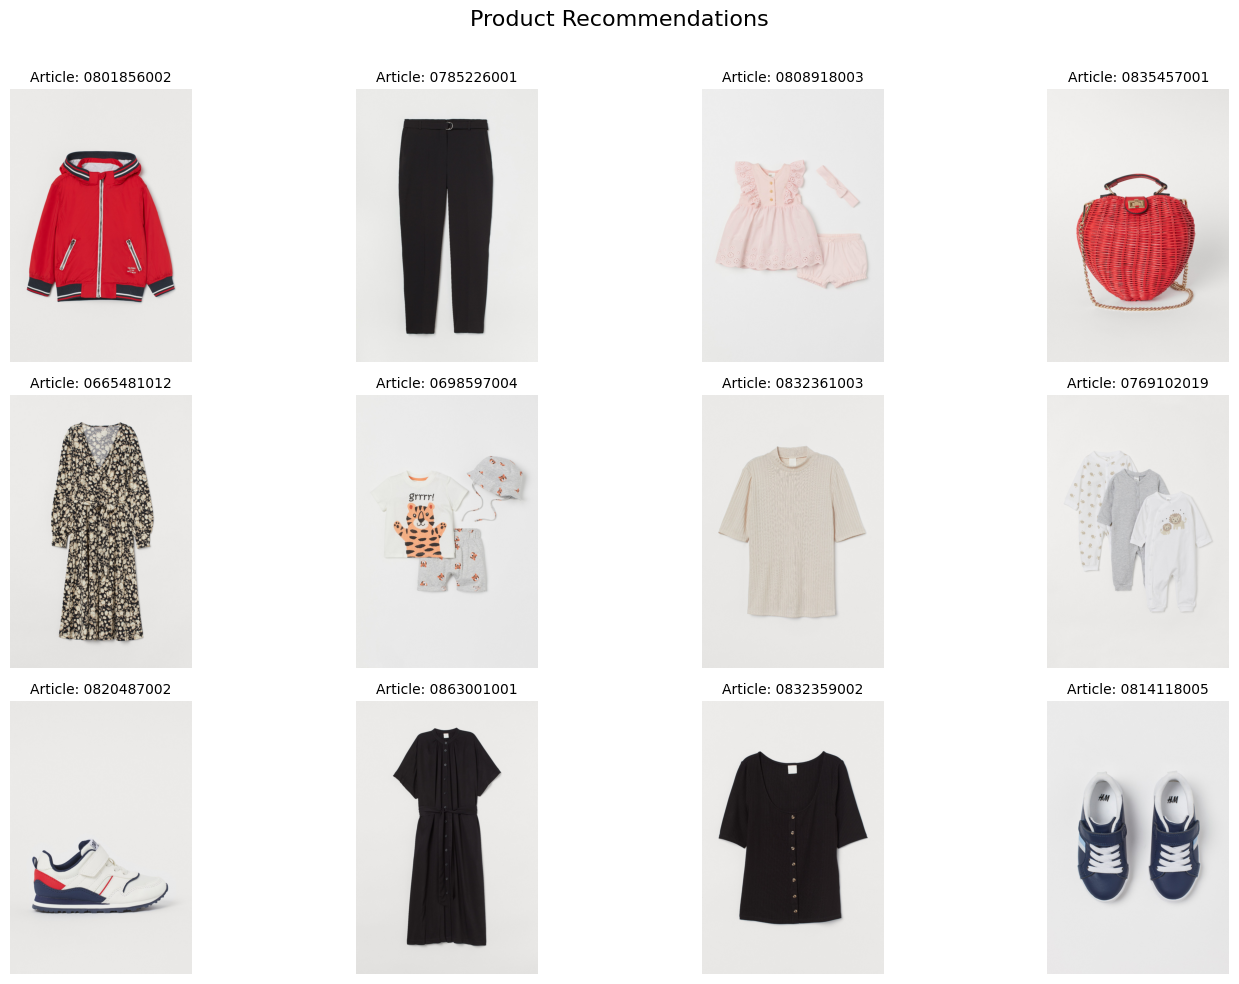

In [88]:
if VIZ:
    # generate recommendations for a user
    example_customer_id = transactions[ transactions['article_id'] == example_article_id]['customer_id'].iloc[1]
    history = transactions[transactions['customer_id'] == example_customer_id]['article_id'].tolist()
    
    recommendations = base_model.get_recommendations(
        history=history,
        top_n=12,
        strategy='weighted_mean',
        recency_bias=True
    )
    
    print(f"Recommendations for customer {example_customer_id}:")
    print(recommendations)
    print('\n')
    
    display_multiple_items(recommendations, title="Product Recommendations")


Customer purchase history: 44 items


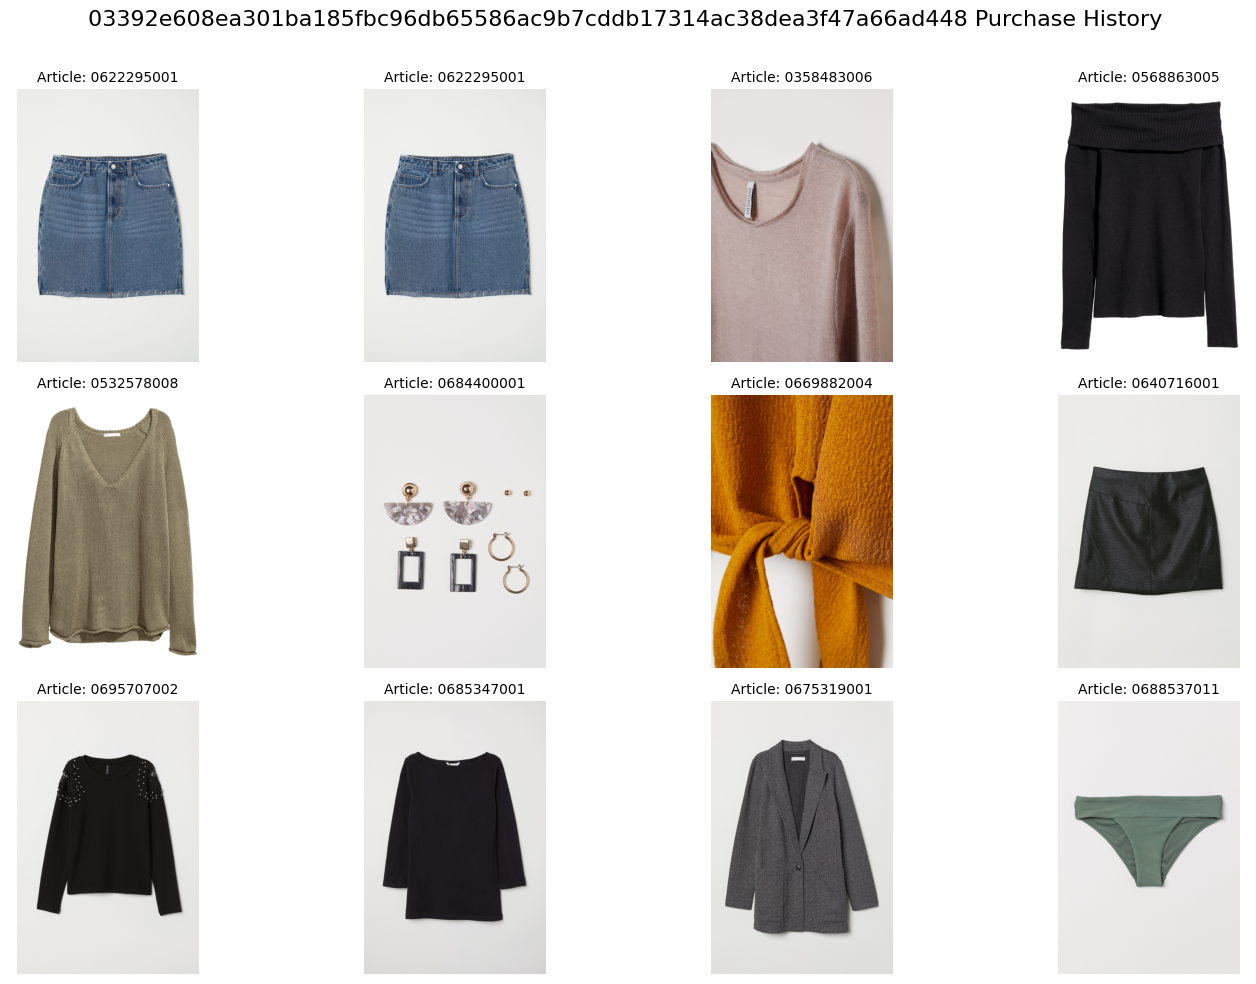


Displaying 12 recommendations for customer 03392e608ea301ba185fbc96db65586ac9b7cddb17314ac38dea3f47a66ad448


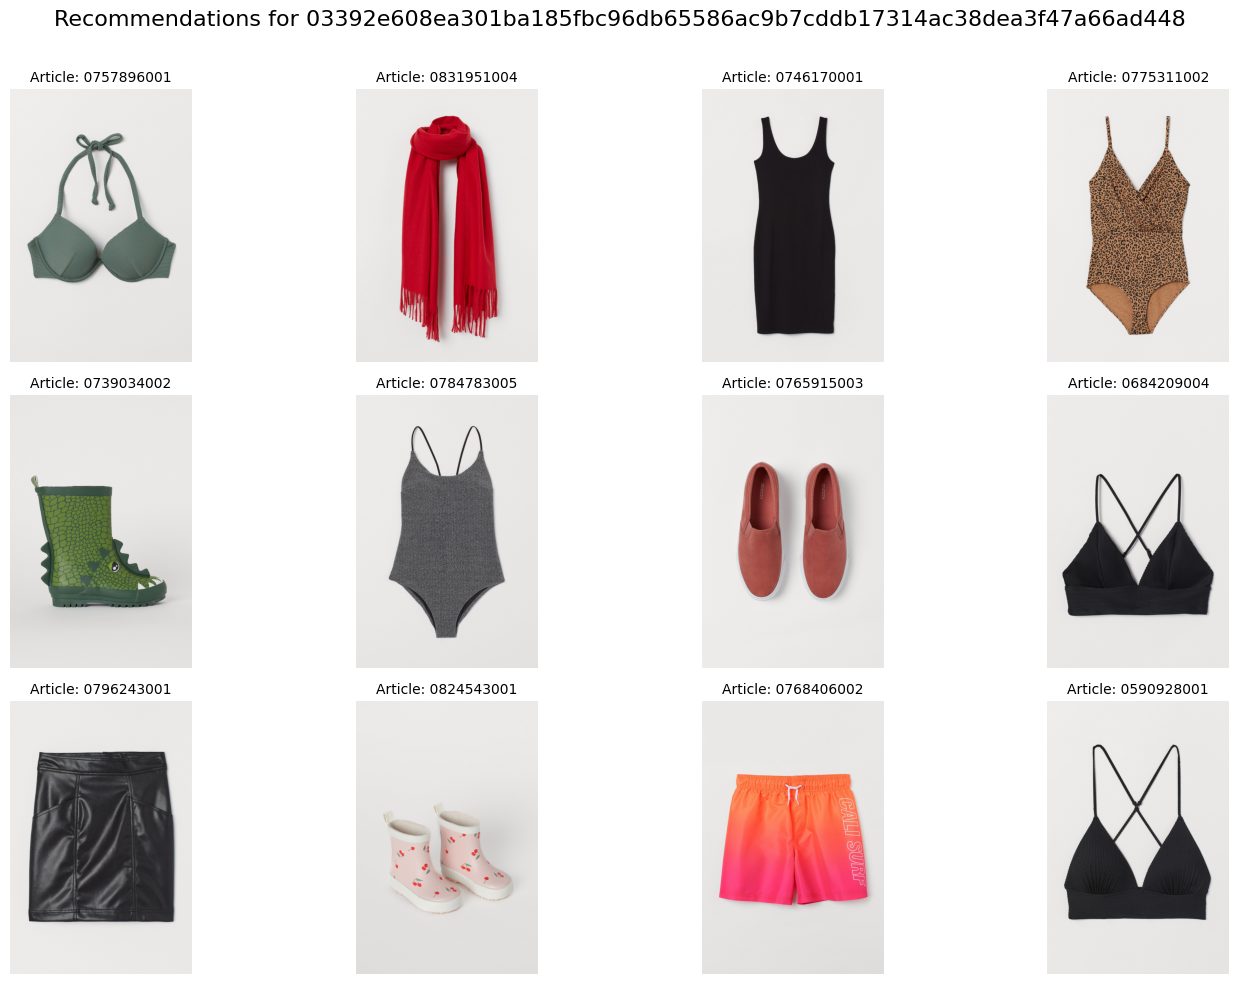

In [89]:
if VIZ:
    example_customer_id2 = transactions['customer_id'].iloc[np.random.randint(1000)]
    show_customer_recommendations(example_customer_id2, base_model, transactions, articles_df=articles)

Visualize embeddings using t-SNE:

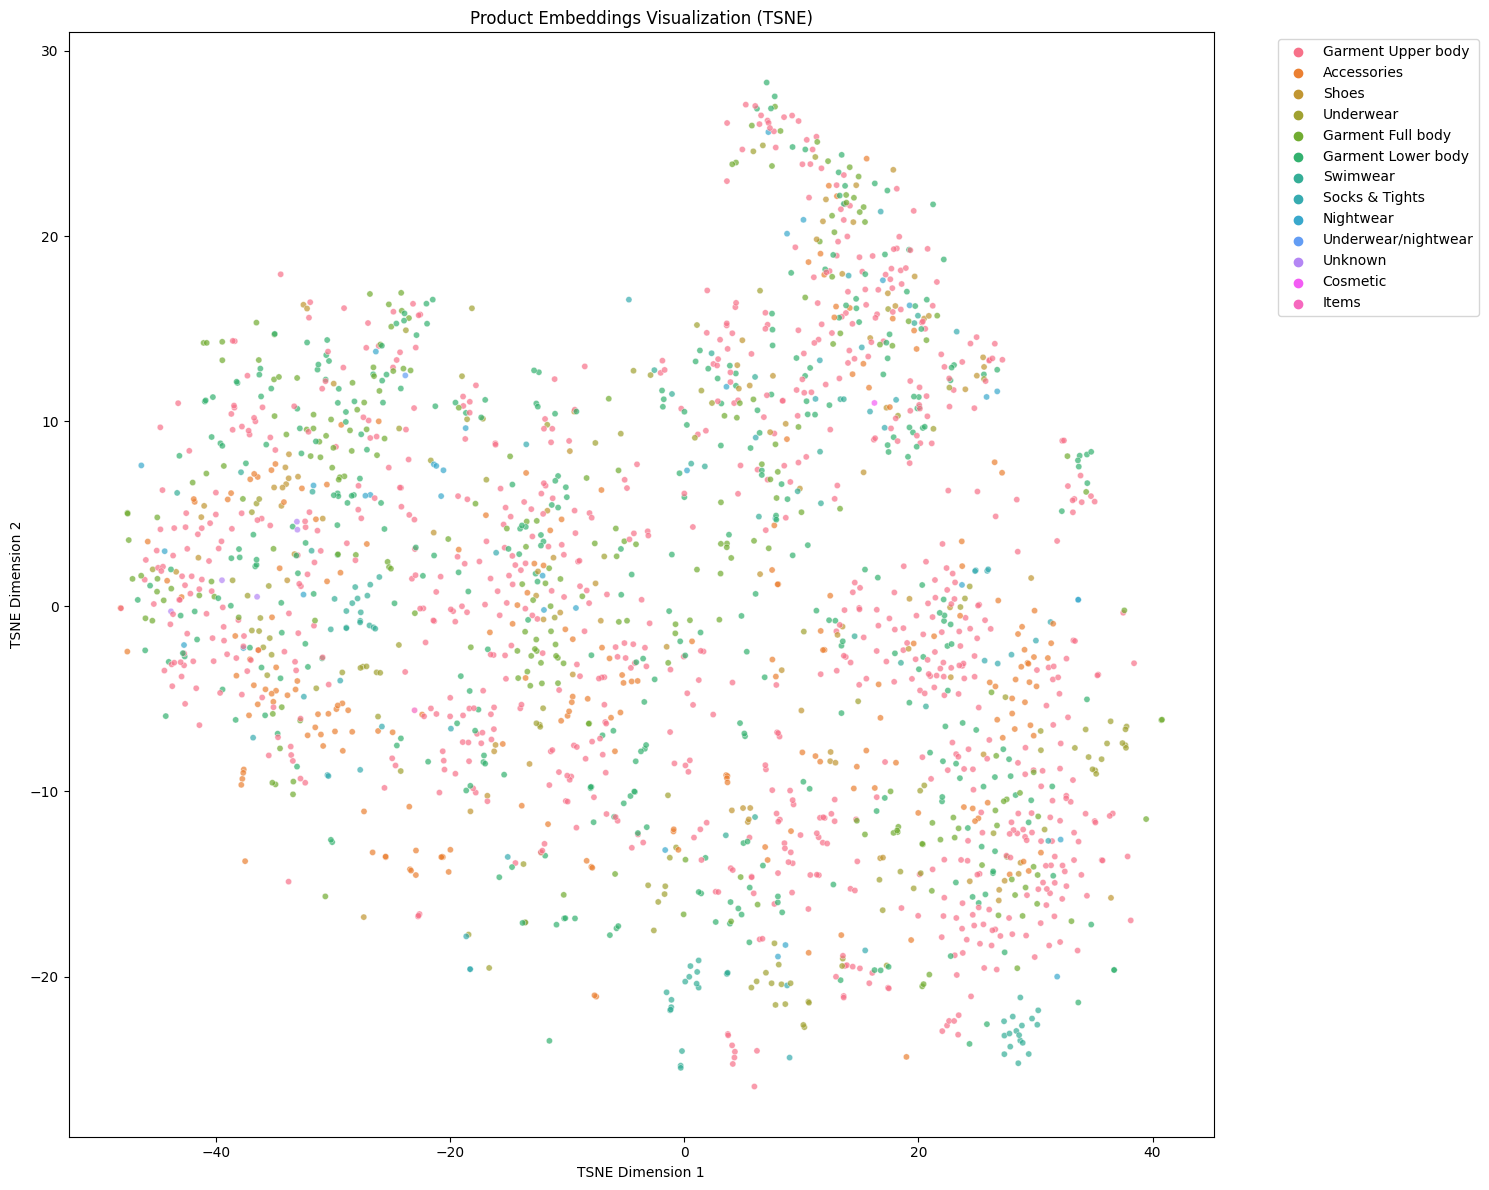

In [90]:
if VIZ:
    tsne_fig = visualize_embeddings(
        base_model, 
        articles, 
        dim_reduction='tsne', 
        n_items=2000, 
        color_by='product_group_name',
        figsize=(15, 12)
    )

Visualize embeddings using UMAP:

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


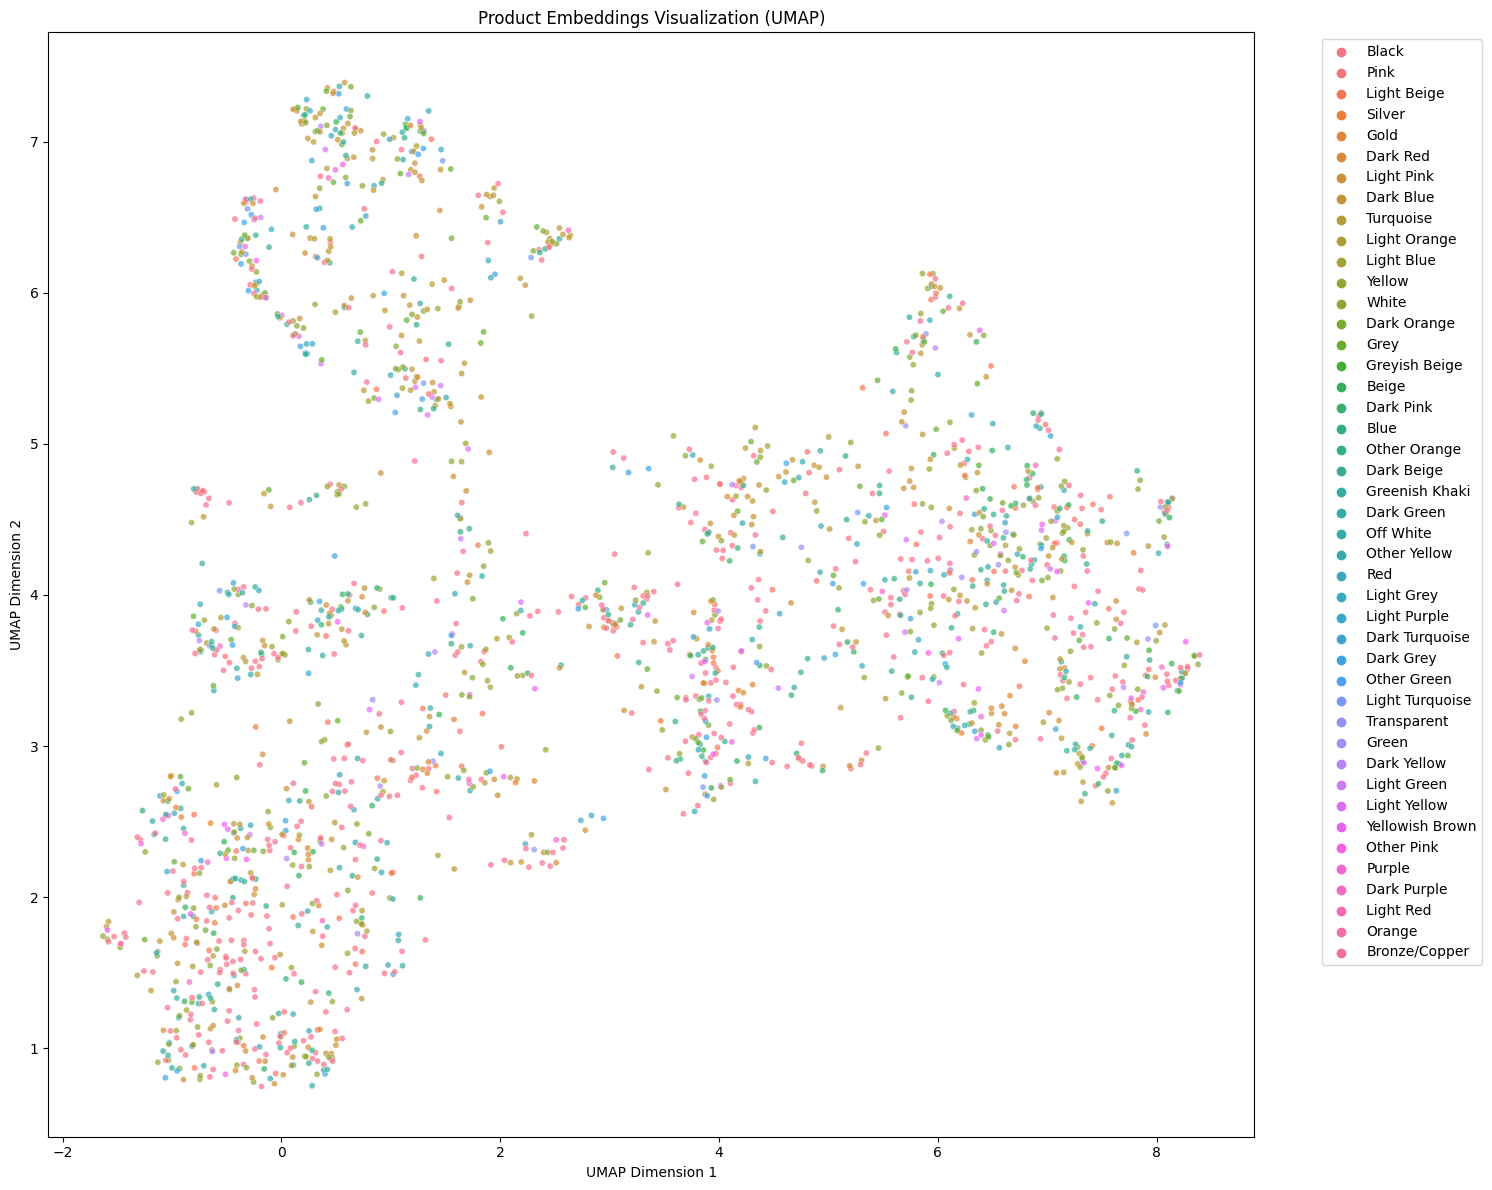

In [91]:
if VIZ:
    umap_fig = visualize_embeddings(
        base_model, 
        articles, 
        dim_reduction='umap', 
        n_items=2000, 
        color_by='colour_group_name',
        figsize=(15, 12)
    )

## 9. Fine-tuning and Optimizations

The model implementation includes several key optimizations. In order to use memory efficiently on such a large dataset with limited compute power, the data processing was chunked and parallelized using process pool executor and thread pool executor. Garbage collection after memory-intensive operations also proved to spare room in memory. The model hyperparameter tuning focused on the architecture of the model in terms of overall efficiency. For example, hierarchical softmax was implemented to replace negative sampling for efficiency. Also, recency bias in user vector computation was activated to emphasize recent purchases, and batch similarity computation was impemented for faster recommendations. These optimizations were important for making the appraoch scalable to the full dataset while maintaining reasonable computation times.

## 10. Submission

In [70]:
def create_submission_file(model, transactions, sample_submission_path, output_path, popular_items,
                          strategy='weighted_mean', recency_bias=True, top_n=12):
    
    print("Creating submission file...")
    
    sample_submission = pd.read_csv(sample_submission_path)
    submission_customers = sample_submission['customer_id'].tolist()
    
    # load or create customer histories as a dictionary
    cache_file = Path(HISTORIES_PATH)
    
    # check if cache exists and is a dictionary
    customer_histories = None
    if cache_file.exists():
        print("Checking cached sequences...")
        with open(cache_file, 'rb') as f:
            customer_histories = pickle.load(f)
        if not isinstance(customer_histories, dict):
            print("Cached file is not a dictionary, regenerating...")
            os.remove(cache_path)  # Delete invalid cache
            customer_histories = None
    
    # generate sequences if no valid cache
    if customer_histories is None:
        customer_histories = create_sequences(
            transactions,
            min_purchases=1,
            cache_path=HISTORIES_PATH,
            return_dict=True,
            chunk_size=5000000
        )
    
    # precompute embedding matrix
    vocab_items = list(model.model.wv.index_to_key)
    embedding_matrix = np.array([model.model.wv[item] for item in vocab_items])
    
    def process_batch(customer_batch):
        batch_recs = {}
        for customer_id in customer_batch:
            history = customer_histories.get(customer_id, [])
            
            if history:
                valid_history = [item for item in history if item in model.model.wv.key_to_index]
                
                if valid_history:
                    
                    # user vector
                    history_embeddings = np.array([model.model.wv[item] for item in valid_history])
                    weights = np.linspace(0.5, 1.0, len(valid_history)) if recency_bias else np.ones(len(valid_history))
                    user_vector = np.average(history_embeddings, axis=0, weights=weights)
                    
                    # batch similarity
                    norm_user = user_vector / np.linalg.norm(user_vector)
                    norm_embeddings = embedding_matrix / np.linalg.norm(embedding_matrix, axis=1, keepdims=True)
                    similarities = np.dot(norm_embeddings, norm_user)
                    
                    # exclude history
                    valid_indices = [i for i, item in enumerate(vocab_items) if item not in set(valid_history)]
                    similarities = similarities[valid_indices]
                    valid_items = [vocab_items[i] for i in valid_indices]
                    
                    # Top-N
                    top_indices = np.argsort(similarities)[::-1][:top_n]
                    recs = [valid_items[i] for i in top_indices]
                    
                else:
                    recs = popular_items
                    
            else:
                recs = popular_items
                
            batch_recs[customer_id] = recs
        
        return batch_recs
    
    batch_size = 1000
    recommendations = {}
    with ThreadPoolExecutor(max_workers=4) as executor:
        futures = [
            executor.submit(process_batch, submission_customers[i:i + batch_size])
            for i in range(0, len(submission_customers), batch_size)
        ]
        for future in tqdm(futures, desc="Generating recommendations"):
            recommendations.update(future.result())
    
    # Create submission
    submission = pd.DataFrame({
        'customer_id': submission_customers,
        'prediction': [' '.join(recommendations.get(cid, popular_items)) for cid in submission_customers]
    })
    
    submission.to_csv(output_path, index=False)
    print(f"Submission file saved to {output_path}")
    return submission

In [38]:
if TRAIN_NEW_MODEL:
    submission = create_submission_file(
        model=base_model,
        transactions=transactions,
        sample_submission_path=SAMPLE_SUBMISSIONS,
        output_path=SUBMISSIONS,
        popular_items=popular_items
    )
else:
    submission = pd.csv_read(SUBMISSIONS)

Creating submission file...
Checking cached sequences...


Generating recommendations: 100%|██████████| 1372/1372 [2:52:42<00:00,  7.55s/it] 


Submission file saved to /kaggle/working/submission.csv


In [39]:
# explore submission data
print("submission dataset info:")
print(f"Shape: {submission.shape}")
print(f"Columns: {submission.columns.tolist()}")
print("\nSample customers:")
submission.head()

submission dataset info:
Shape: (1371980, 2)
Columns: ['customer_id', 'prediction']

Sample customers:


customer_id  \
0  00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...   
1  0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...   
2  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   
3  00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...   
4  00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...   

                                          prediction  
0  0706016001 0706016002 0372860001 0610776002 07...  
1  0666448001 0666448004 0666448005 0699358002 06...  
2  0577033005 0678079006 0650037001 0542677002 06...  
3  0706016001 0706016002 0372860001 0610776002 07...  
4  0706016001 0706016002 0372860001 0610776002 07...

## 11. Conclusion

The implementation of Product2Vec for H&M fashion recommendations demonstrates the potential of embedding-based approaches for recommendor systems. 

Several limitations of the current iteration are earmarked for improvement in the future. The model in its current state does not utilize temporal information other than recency bias. Additionally, the model faces a cold-start problem where customers with very few purchases and new products receive lower quality recommendations.

In future work, I plan to utilize the temporal information more heavily, fine-tune the base hyperparameters like sequence length, window size, skip-gram, and possibly add attention mechanisms. But, as an exercise in unsupervised learning, I believe that this notebook is a solid foundation.